In [1]:
import keras
from keras.layers import Dense,Softmax,Dropout
from keras import regularizers
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score
from IPython.display import display, HTML
from bayes_opt import BayesianOptimization

tonpyarray = lambda x: np.asarray(x).astype('float32')

## Przygotowanie danych

In [7]:
 link = "https://lovespreadsheet-tutorials.s3.amazonaws.com/APIDatasets/gender_voice_dataset.csv"
 data = pd.read_csv(link)

In [8]:
# Przygotowanie danych do trenowania
x_train, x_test, y_train, y_test = train_test_split(
    data.iloc[:,:-1], data['label'], stratify=data['label'], test_size=0.2, random_state=7
)

# One hot encoding dla zmiennej label
label_function = lambda s: 1 if s=="male" else 0
y_train = tonpyarray(list(y_train.apply(label_function)))
y_test = tonpyarray(list(y_test.apply(label_function)))

## Porównywanie efektywności

In [11]:
# Przygotowanie funkcji do zapisu efektywności modeli
results = pd.DataFrame({'Label': [], 'Sublabel': [], 'Accuracy': [], 'Recall': [], 'Precision': []})
def evaluateResult(y_pred, label, sublabel="", display=True):
    acc = accuracy_score(y_test,y_pred)
    rec = recall_score(y_test,y_pred,average='weighted')
    prec = precision_score(y_test,y_pred,average='weighted')
    
    results.loc[label+(" - "+sublabel if sublabel!="" else "")] = [label, sublabel, acc, rec, prec]
    
    if(display):
        print("Accuracy: "+str(acc))
        print("Recall: "+str(rec))
        print("Precision: "+str(prec))
        
    return acc

Modele będziemy porównywać względem trzech metryk - `accuracy`, `recall` i `precision`, z czego największy nacisk będziemy kładli na `accuracy`. Powyższa funkcja oblicza wartości dla każdej z tych metryk i zapisuje je do późniejszego porównywania.

In [12]:
def displayResults(label, title):
    # Przygotowanie danych do wyświetlenia
    displayData = pd.DataFrame({'Accuracy': [], 'Recall': [], 'Precision': []})
    
    # Umieszczenie baselinu dla porównania
    displayData.loc['Baseline'] = results.loc['Baseline'][['Accuracy', 'Recall', 'Precision']]
    
    # Dodanie wszystkich pasujących wierszy
    matchLabel = results[results.Label == label]
    displayData = displayData.append(matchLabel[['Accuracy', 'Recall', 'Precision']].set_axis(matchLabel.Sublabel.values))
    
    
    # Utworzenie wykresu
    plotData = displayData.copy()
    plotData[""] = plotData.index
    plotData = plotData.melt('', var_name="Score", value_name="Value")
    
    # Wyświetlenie wyników
    sns.catplot(x="", y="Value", hue="Score", data=plotData, kind="bar", height=6, aspect=1.7).fig.suptitle(title)
    plt.ylim(0.8, 1)
    plt.show()
    display(displayData.T)

Przygotujemy także funkcję pozwalającą nam na porównanie modeli w sposób wizualny, za pomocą wykresu i tabelki z dokładnymi wartościami.

## Baseline

Jako baseline weźmiemy model bazujący na podstawie jednej zmiennej i prostego warunku.

In [22]:
# Model działający na podstawie jednego if-a
y_baseline = x_test.copy()
y_baseline.loc[:,"label"] = 0
y_baseline.loc[y_baseline.meanfun < 0.145,"label"] = 1

suppress = evaluateResult(y_baseline["label"], "Baseline")

Accuracy: 0.9542586750788643
Recall: 0.9542586750788643
Precision: 0.9544802867383513


Widać, że nawet przy tak prostym modelu, wykorzystującym tylko jedną zmienną, udaje nam się uzyskać dokładność na poziomie 95%. Zatem, jeżeli zależałoby nam przede wszystkim na szybkości model, ten jest wystaczającym rozwiązaniem. Będziemy jednak chcieli stworzyć model który uzyskuje większą dokładność kosztem jego prędkości.

## Nasz model

Po poprzedniej analizie modeli doszliśmy do wniosku że najlepszym rozwiązaniem będzie wykorzystanie boosted trees. Najlepszą dokładność uzyskaliśmy wykorzystując wszystkie dostępne zmienne, jednak chcielibyśmy ograniczyć ilość tych zmiennych i zobaczyć jak model się wtedy zachowa.

In [4]:
# Wyłączenie wyświetlania informacji debugowych
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Przetworzenie danych na funkcje dla tensorflowa
def make_input_fn(x, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x.to_dict(orient='list'), y))
    if shuffle:
      dataset = dataset.shuffle(2534)
    dataset = (dataset
      .repeat(n_epochs)
      .batch(2534))
    return dataset
  return input_fn

# Przygotowanie zmiennych pomocniczych do boosted trees
def prepareForBoostedTrees(columns):
    feature_columns = []
    for feature_name in columns:
        feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

    train_input_fn = make_input_fn(x_train[columns], y_train)
    eval_input_fn = make_input_fn(x_test[columns], y_test, shuffle=False, n_epochs=1)
    
    return (feature_columns, train_input_fn, eval_input_fn)

*Kod stworzony na bazie [tej części dokumentacji](https://www.tensorflow.org/tutorials/estimator/boosted_trees_model_understanding).*

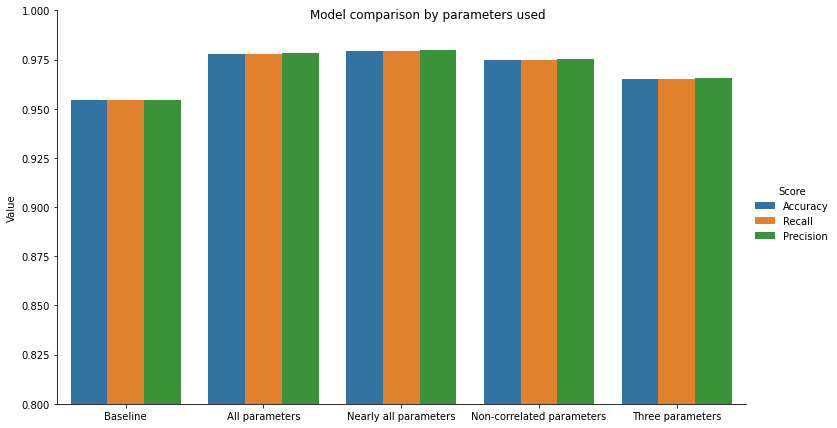

,Baseline,All parameters,Nearly all parameters,Non-correlated parameters,Three parameters
Accuracy,0.954259,0.977918,0.979495,0.974763,0.965300
Recall,0.954259,0.977918,0.979495,0.974763,0.965300
Precision,0.954480,0.978223,0.979882,0.975445,0.965763


In [125]:
def trainBoostedTrees(columns, label):
    params = {
      'n_trees': 100,
      'max_depth': 6,
      'n_batches_per_layer': 1,
      'center_bias': True
    }
    feature_columns, train_input_fn, eval_input_fn = prepareForBoostedTrees(columns)
    
    model = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
    model.train(train_input_fn, max_steps=600)
    
    y_pred = model.predict(eval_input_fn)
    y_pred = tonpyarray([item['classes'][0] for item in y_pred]) # Konwersja wyników aby zgadzały się typem
    
    evaluateResult(y_pred, "Boosted Trees", label, False)

trainBoostedTrees(list(data.columns[:-1]), "All parameters")
trainBoostedTrees(["meanfreq","skew","mode","meanfun","minfun","maxfun","meandom","mindom","modindx","sd","median","Q25","Q75","IQR","sp.ent","sfm","maxdom"], "Nearly all parameters")
trainBoostedTrees(["meanfreq","skew","mode","meanfun","minfun","maxfun","meandom","mindom","modindx"], "Non-correlated parameters")
trainBoostedTrees(['IQR','Q25','meanfun'], "Three parameters")
displayResults("Boosted Trees", "Model comparison by parameters used")

Porównujemy efektywność modeli w zależności od tego jakich parametrów użyjemy. Dobór parametrów bazowany jest na korelacji analizowanej podczas eksploracji danych.   
Widzimy że najlepszy wynik uzyskujemy dla wykorzystania "prawie wszystkich parametrów", czyli wszystkich poza `kurt`, `centroid` i `dfrange`, które są bardzo mocno skorelowane z innymi zmiennymi.



## Strojenie hiperparametrów

Do dalszych rozważań będziemy uwzględniać właśnie model z prawie wszystkimi parametrami. Chcemy dobrać hiperparametry `n_trees` i `max_depth` tak, aby uzyskać jak największą dokładność modelu. Użyjemy do tego gotowej biblioteki która przeprowadzi optymalizację bayesowską.

In [18]:
feature_columns, train_input_fn, eval_input_fn = prepareForBoostedTrees(["meanfreq","skew","mode","meanfun","minfun","maxfun","meandom","mindom","modindx","sd","median","Q25","Q75","IQR","sp.ent","sfm","maxdom"])
def optimizeHiperparameters(n_trees, max_depth):
    n_trees = round(n_trees)
    max_depth = round(max_depth)
    
    params = {
      'n_trees': n_trees,
      'max_depth': max_depth,
      'n_batches_per_layer': 1,
      'center_bias': True
    }
    
    model = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
    model.train(train_input_fn, max_steps=600)
    
    y_pred = model.predict(eval_input_fn)
    y_pred = tonpyarray([item['classes'][0] for item in y_pred]) # Konwersja wyników aby zgadzały się typem
    
    return evaluateResult(y_pred, "Hiperparemeters", "Trees: "+str(n_trees)+"\nDepth: "+str(max_depth), False)

# Ustawienie zakresu do optymalizacji
pbounds = {'n_trees': (70, 300), 'max_depth': (4, 10)}

# Optymalizacja bayesowska
optimizer = BayesianOptimization(
    f=optimizeHiperparameters,
    pbounds=pbounds,
    random_state=1,
)
optimizer.maximize(
    init_points=4,
    n_iter=16,
)
print("Best accuracy: ")
print(optimizer.max)

|   iter    |  target   | max_depth |  n_trees  |
-------------------------------------------------
|  1        |  0.9779   |  6.502    |  235.7    |
|  2        |  0.9779   |  4.001    |  139.5    |
|  3        |  0.9795   |  4.881    |  91.24    |


c:\users\filmos\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


|  4        |  0.5      |  5.118    |  149.5    |
|  5        |  0.9811   |  4.234    |  139.5    |
|  6        |  0.9779   |  4.0      |  130.5    |
|  7        |  0.9779   |  5.022    |  103.1    |
|  8        |  0.9779   |  7.628    |  115.7    |
|  9        |  0.9811   |  6.485    |  247.9    |
|  10       |  0.9795   |  10.0     |  259.7    |
|  11       |  0.9779   |  4.0      |  270.4    |
|  12       |  0.9763   |  9.786    |  281.2    |
|  13       |  0.9779   |  9.955    |  80.24    |
|  14       |  0.9811   |  4.201    |  70.2     |
|  15       |  0.9779   |  9.894    |  223.7    |
|  16       |  0.9795   |  4.202    |  212.8    |
|  17       |  0.9763   |  9.639    |  202.0    |
|  18       |  0.9795   |  4.139    |  292.2    |
|  19       |  0.9795   |  4.0      |  191.3    |
|  20       |  0.9779   |  10.0     |  181.4    |
Best accuracy: 
{'target': 0.9810725552050473, 'params': {'max_depth': 4.2335082401529505, 'n_trees': 139.4527163842324}}


Po wybraniu najlepszego zestawu otrzymujemy dokładność na poziomie 98%.  
Pomimo zmiany hiperparametrów nie ma dużej różnicy w dokładności naszego modelu, większość różnic jest spowodowana losowością boosted trees. 

## Finalny model

Jako ostateczna próba zwiększenia dokładności zwiększymy długość trenowania naszego modelu i zobaczymy jak to wpłynie na jakość modelu.

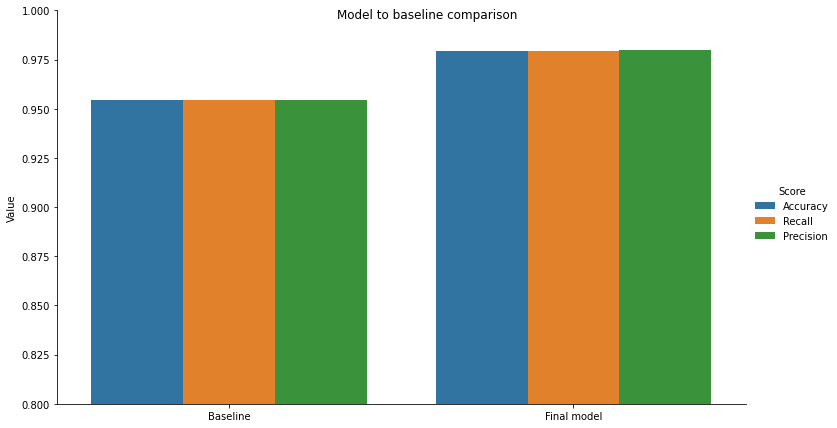

,Baseline,Final model
Accuracy,0.954259,0.979495
Recall,0.954259,0.979495
Precision,0.954480,0.979729


In [24]:
params = {
  'n_trees': 140,
  'max_depth': 4,
  'n_batches_per_layer': 1,
  'center_bias': True
}

model = tf.estimator.BoostedTreesClassifier(feature_columns, **params)
model.train(train_input_fn, max_steps=2000)

y_pred = model.predict(eval_input_fn)
y_pred = tonpyarray([item['classes'][0] for item in y_pred]) # Konwersja wyników aby zgadzały się typem

evaluateResult(y_pred, "Final model", "Final model", False)
displayResults("Final model", "Model to baseline comparison")

Dłuższy czas trenowania nie poprawił jakości modelu. Tak jak było wspomnianie to wcześniej, minimalny spadek dokładności jest spowodowany losowością boosted trees.  

Podsumowując, używając wyłącznie jednego if-a jesteśmy w stanie uzyskać dokładność na poziomie 95%, co może być przydatne jeśli bardzo zależy nam na szybkości modelu. Jeżeli chcielibyśmy uzyskać dokładniejszy model to najlepszym rozwiązaniem wydaje się użycie boosted trees na zbiorze danych z wyłączeniem bardzo mocno skorelowanych zmiennych (`kurt`, `centroid` i `dfrange`). Dla takiego modelu `accuracy`, `recall` oraz `precision` wynoszą 98%, co jest bardzo dobrym wynikiem.